# Covasim

## Simulator

Covasim is a stochastic agent-based simulator for performing COVID-19 analyses. These include projections of indicators such as numbers of infections and peak hospital demand. It can also be used to explore the potential impact of different interventions, including social distancing, school closures, testing, contact tracing, quarantine, and vaccination.

You can think of each agent as a node in a mathematical graph, and each connection as an edge. By default, Covasim creates a single random contact network where each agent is connected to 20 other agents, completely at random.

For greater realism, Covasim also comes with different population types, which can create generic populations with different network characteristics based on the selected location (default is Seattle), and that interact in different layers (households `h`, schools `s`, workplaces `w`, and community interactions `c`).

The scientific paper describing Covasim is available at http://paper.covasim.org.

## Running a Simulation

Running simulations in Covasim can be done using the `cv.Sim()` command, which accepts a dictionary of simulation parameters. The most common parameters to modify are the population size, the initial number of infected people, and the start and end dates of the simulation. A comprehensive list of parameters is available [here](https://docs.idmod.org/projects/covasim/en/latest/parameters.html).

The `hybrid` population type is the best trade-off between computational cost (set to `random` if efficiency is an issue) and realistic interaction among agents (set to `synthpops` for the maximum reliability).

In [1]:
import covasim as cv

fixed_pars = dict(
  pop_type='hybrid',
  pop_size=50e3,
  pop_infected=100,
  start_day='2020-02-24',
  end_day='2020-05-24',
)

sim = cv.Sim(fixed_pars)

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


All the parameters which are not explicitly defined but are necessary for the simulation have a default value.

These are the default values of some parameters which may be of interest.

In [2]:
parameters = [
 'beta',         # beta per symptomatic contact
 'contacts',     # the number of contacts per layer
 'beta_layer',   # transmissibility per layer
 'n_imports',    # average daily number of imported cases (actual number is drawn from Poisson distribution)
 'asymp_factor', # multiply beta by this factor for asymptomatic cases
 'iso_factor',   # multiply beta by this factor for diagnosed cases to represent isolation
 'quar_factor',  # quarantine multiplier on transmissibility and susceptibility
 'quar_period'   # number of days to quarantine for
]

for key in parameters:
  print(f'{key:13} --> {sim[key]}')

beta          --> 0.016
contacts      --> {'h': 2.0, 's': 20, 'w': 16, 'c': 20}
beta_layer    --> {'h': 3.0, 's': 0.6, 'w': 0.6, 'c': 0.3}
n_imports     --> 0
asymp_factor  --> 1.0
iso_factor    --> {'h': 0.3, 's': 0.1, 'w': 0.1, 'c': 0.1}
quar_factor   --> {'h': 0.6, 's': 0.2, 'w': 0.2, 'c': 0.2}
quar_period   --> 14


The execution of a simulation produces the following results:

In [3]:
sim.run();

Initializing sim with 50000 people for 90 days
  Running 2020-02-24 ( 0/90) (2.73 s)  ———————————————————— 1%
  Running 2020-03-05 (10/90) (3.04 s)  ••—————————————————— 12%
  Running 2020-03-15 (20/90) (3.45 s)  ••••———————————————— 23%
  Running 2020-03-25 (30/90) (3.98 s)  ••••••—————————————— 34%
  Running 2020-04-04 (40/90) (4.36 s)  •••••••••——————————— 45%
  Running 2020-04-14 (50/90) (4.80 s)  •••••••••••————————— 56%
  Running 2020-04-24 (60/90) (5.25 s)  •••••••••••••——————— 67%
  Running 2020-05-04 (70/90) (5.63 s)  •••••••••••••••————— 78%
  Running 2020-05-14 (80/90) (5.98 s)  •••••••••••••••••——— 89%
  Running 2020-05-24 (90/90) (6.30 s)  •••••••••••••••••••• 100%

Simulation summary:
   41041 cumulative infections
   40926 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
   40069 cumulative recoveries
   27694 cumulative symptomatic cases
    2150 cumulative severe cases
     616 cumulative critical cases
     224 cumulative deaths
       0 c

## Running multiple simulations

As we are aiming to use Covasim to generate realistic data, we will need to run more than one simulation simultaneously. The most common way to run multiple simulations is with the `MultiSim` object. As the name suggests, this is a relatively simple container for a number of sims. However, it contains powerful methods for plotting, statistics, and running all the sims in parallel.

We rely on our utility function `cartesian_product` to generate a list of python dictionaries containing all the possible combinations of the parameters that we are willing to explore. In the end, the total number of configurations will be given by the product of the number of values which can be assumed by each variable parameter. E.g., in this case, we have three possible values for `rand_seed` and two possible values for `beta`, for a total of $3 \cdot 2 = 6$ configurations.

In [4]:
from src import comb

multi_pars = [(k, v) for k, v in dict(
  rand_seed = range(3),
  beta = [0.01, 0.02]
).items()]
fixed_pars['verbose'] = 0
pars_list = comb.cartesian_product(multi_pars, fixed_pars)
len(pars_list)

6

We can now map each configuration into a Covasim `Sim` object, and then create and run the `MultiSim`.

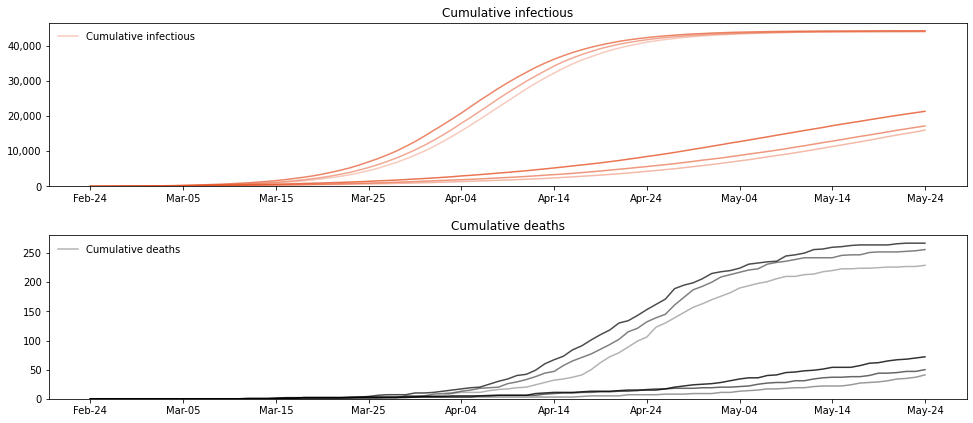

In [5]:
sims = [cv.Sim(pars, label=f'Sim {i}') for i, pars in enumerate(pars_list)]
msim = cv.MultiSim(sims)
msim.run()
msim.plot(['cum_infectious', 'cum_deaths'], fig_args={"figsize": (15, 6)});

# Interventions

## Purpose

It is possible to modify the parameters of the simulation during the execution via a set of explicit rules. This can come handy to reproduce the effect of the adopted countermeasures.
We have decided to cover the following interventions: 

* number of tests 
* contact tracing 
* lockdown, smart working, schools closed
* imported cases 
* viral load

In order to have a deeper knowledge about the effect of each of them, let's see what is their effect on a simulation.

In [6]:
def interventions_effect(interventions, label="Intervention"):
    sim_base = cv.Sim(fixed_pars, label="Base")
    sim_tests = cv.Sim(fixed_pars, interventions=interventions, label=label)
    msim = cv.MultiSim([sim_base, sim_tests])
    msim.run()
    return msim

## Tests

Performing tests on the population can be helpful to detect infected people and isolate them as soon as possible. Covasim provides the method `test_num` for this operation:

* `daily_tests`: the number of tests made daily (you can provide a different number for each day)
* `quar_policy`: when a quarantined agent must perform the test (`both` means both at the beginning and at the end)
* `sensitivity`: the percentage of tests correctly detecting a positive case

In [7]:
tests = cv.test_num(daily_tests=200, quar_policy='both', sensitivity=0.8, do_plot=False)
msim = interventions_effect(interventions=tests, label="Tests")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 41041⚙, 224☠)
    1: Sim("Tests"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 37066⚙, 149☠)



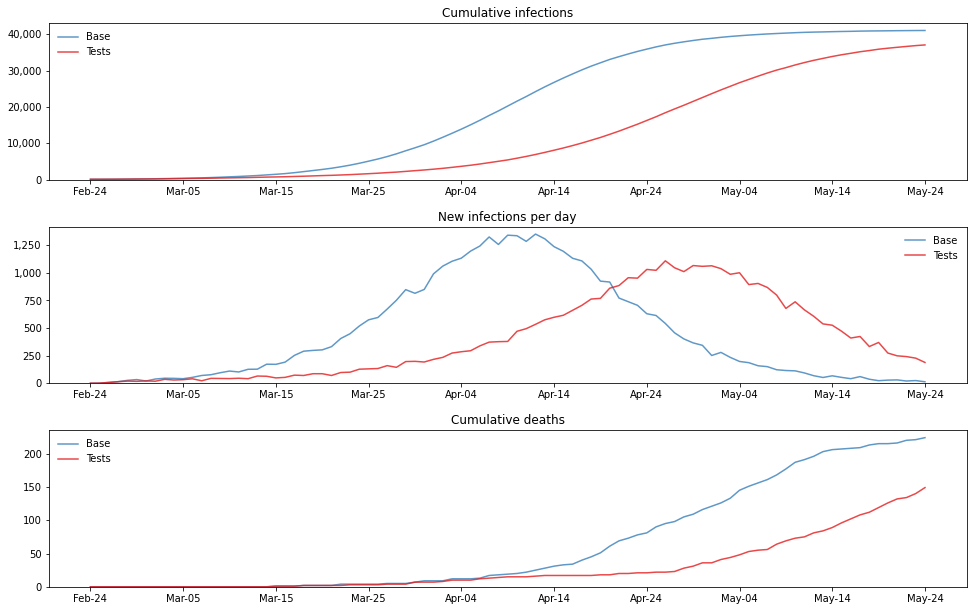

In [8]:
msim.plot(fig_args={"figsize": (15, 9)});

## Contact Tracing

When a person is diagnosed positive by a test, people in contact with him are contacted to be placed into quarantine.

* `trace_prob`: percentage of people connected who is actually traced
* `trace_time`: number of days after which people are contacted

In [9]:
contact_tracing = cv.contact_tracing(trace_probs=0.2, trace_time=3)
msim = interventions_effect(interventions=[tests, contact_tracing], label="Contact Tracing")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 41041⚙, 224☠)
    1: Sim("Contact Tracing"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 25565⚙, 68☠)



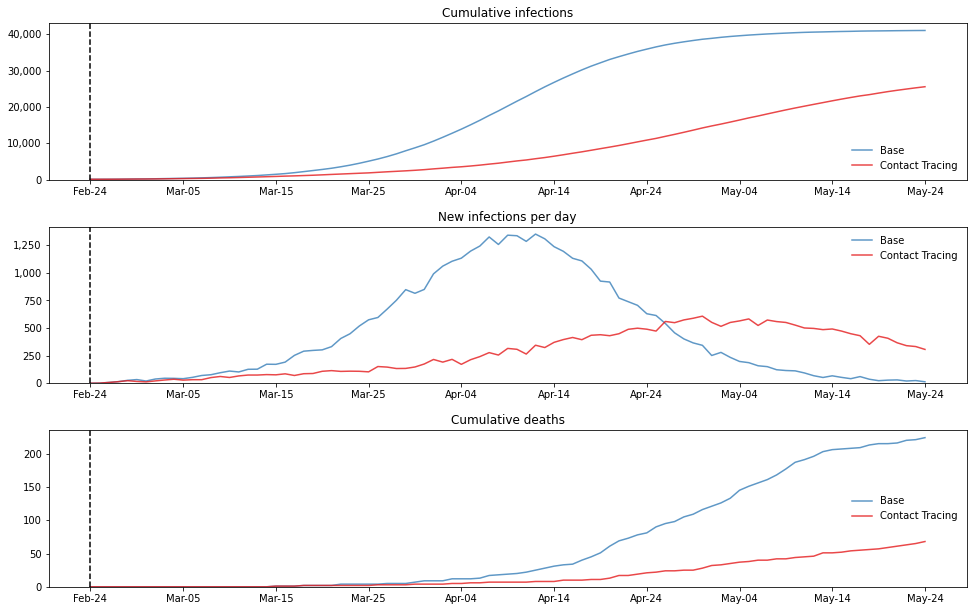

In [10]:
msim.plot(fig_args={"figsize": (15, 9)});

## Lockdown, Smart Working, Schools Closed

All these measures have the effect of reducing the number of contacts between people, the main difference is the simulation layer they act upon (respectively `c`, `w`, and `s`).

* `days`: number of days after which the measure starts;
* `changes`: new percentage of contacts introduced for each specified day.

In [11]:
contacts = cv.clip_edges(days=[45, 60], changes=[0.3, 1.0])
msim = interventions_effect(interventions=contacts, label="Reduce Contacts")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 41041⚙, 224☠)
    1: Sim("Reduce Contacts"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 31692⚙, 147☠)



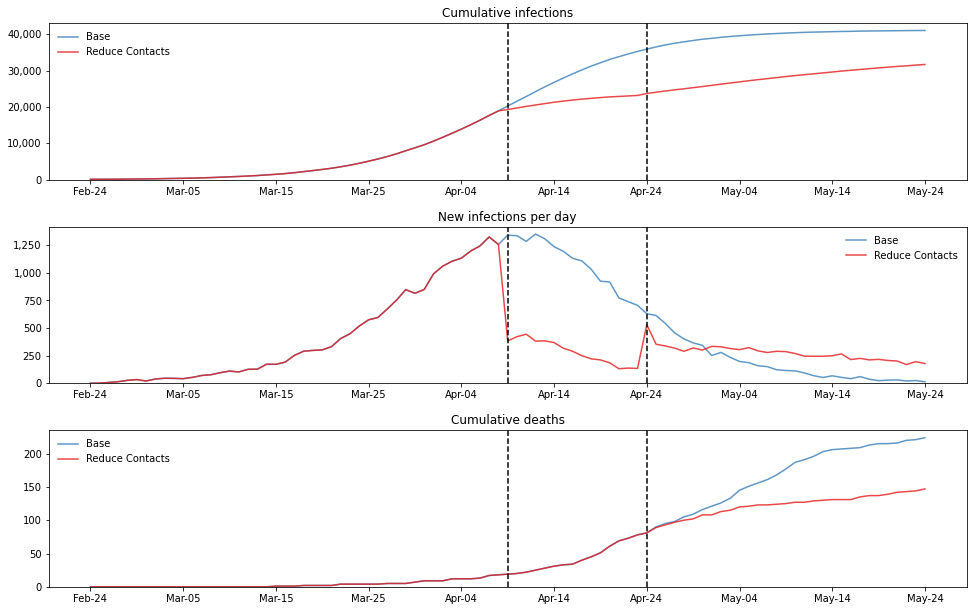

In [12]:
msim.plot(fig_args={"figsize": (15, 9)});

## Imported Cases

Infected people can spontaneously arise without an actual infection happens in the simulation. It is the case, for instance, of people coming from outside the selected location. Differently from the previously discussed interventions, this one does not have a proper method, however, `dynamic_pars` can handle any parameter change given a dictionary of the `days` and the corresponding `vals`. 

In [13]:
imports = cv.dynamic_pars(n_imports=dict(days=30, vals=200))
msim = interventions_effect(interventions=imports, label="Imports")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 41041⚙, 224☠)
    1: Sim("Imports"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 43520⚙, 217☠)



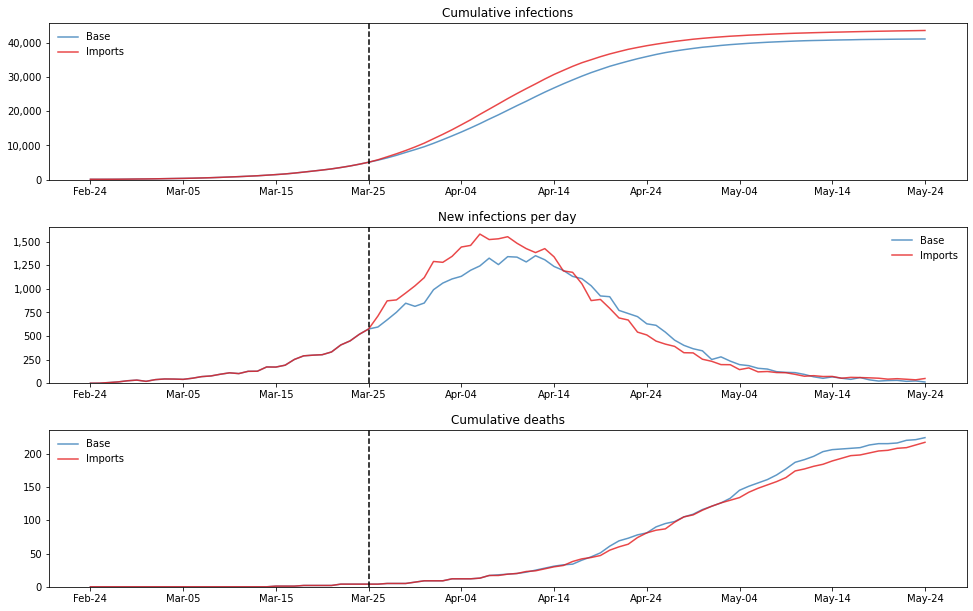

In [14]:
msim.plot(fig_args={"figsize": (15, 9)});

## Viral Load

While `clip_edges` is designed to reduce the number of social contacts specifically, `chenge_beta` is more general and covers all the aspects that may affect the transmission rate of the virus (e.g., hand washing, masks, temperature, etc).

In [15]:
beta = cv.change_beta(days=[45, 60], changes=[0.2, 1.0])
msim = interventions_effect(interventions=beta, label="Beta Change")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 41041⚙, 224☠)
    1: Sim("Beta Change"; 2020-02-24 to 2020-05-24; pop: 50000 hybrid; epi: 30492⚙, 142☠)



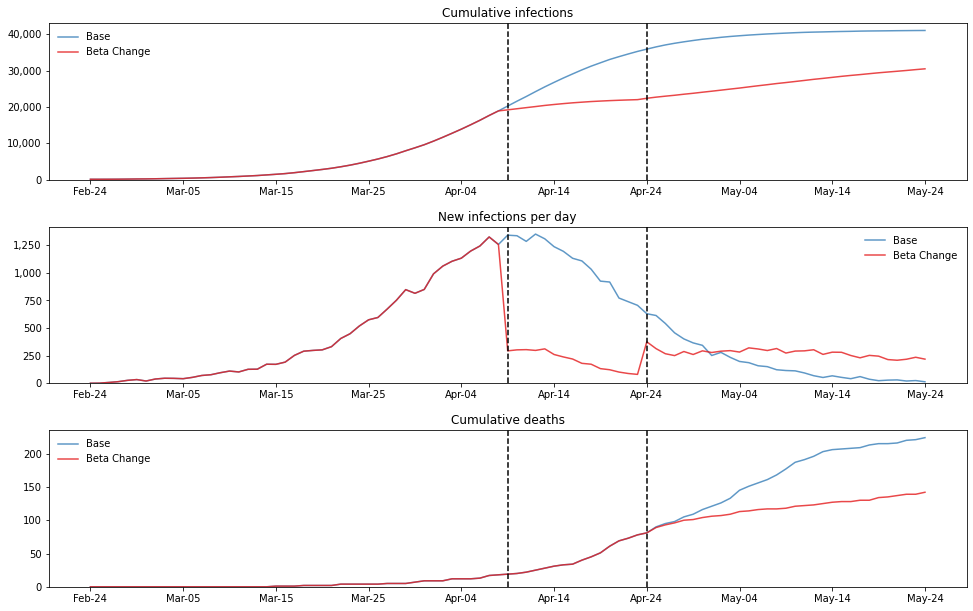

In [16]:
msim.plot(fig_args={"figsize": (15, 9)});

# Scenario

## Default Parameters

Having a better understanding of how Covasim works, we can now focus on a particular case scenario. Specifically, we will try to mimic the evolution of the pandemic during roughly the last year for the italian region of Emilia-Romagna.

Considering the entire population of 4.46 million of people would be too resource heavy, especially if we are planning to run multiple simulations. Moreover, we should also consider that a lower amount of agents is probably representative enough of the whole (thanks inferential statistics). We consider 400k, which is approximately the population of the city of Bologna, a fair amount of simulated people to use.

Since the major concern of the pandemic is the overload of the hospitalized structures, we provide the simulator also the number of *hospital beds* and *icu beds* per person, retrieved from the website of the region Emilia-Romagna.

In [17]:
pop_size = 400e3
n_beds_hosp_pp = 370.4 / 100e3
n_beds_icu_pp = 14.46 / 100e3

Here are the default parameters of our *realistic* simulation (notice that no intervention is used yet):

In [18]:
%%time

default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day='2020-02-24',
    end_day='2021-02-24',
    pop_size=pop_size,
    n_beds_hosp=pop_size * n_beds_hosp_pp,
    n_beds_icu=pop_size * n_beds_icu_pp,
    quar_period=14,
    verbose=0
)

sim = cv.Sim(default_params)
sim.run();

CPU times: user 2min 1s, sys: 1.22 s, total: 2min 2s
Wall time: 2min 5s


Sim(<no label>; 2020-02-24 to 2021-02-24; pop: 400000 hybrid; epi: 323194⚙, 9304☠)

Apart from the fact we can notice almost all would have probably contracted the virus without any countermeasure (at least according to the simulator), waiting *> 1 minute* for obtaining the results of a single simulation is still a huge amount of time...

## Rescaling

Fortunately, Covasim provides us a useful feature: rescaling, which can be used setting the parameter `rescale` to True and proving a `pop_scale`, in this case to 10. 

The effect is that the number of actual agents is reduced by this factor, resulting in 40k agents instead of 400k, but as the simulation proceeds, the states are updated to be significative for the original size of the population.

In [19]:
%%time
pop_scale = 10

default_params_scale = dict(
    pop_type='hybrid',
    location='italy',
    start_day='2020-02-24',
    end_day='2021-02-24',
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * n_beds_hosp_pp,
    n_beds_icu=pop_size * n_beds_icu_pp,
    quar_period=14,
    verbose=0
)

sim_scale = cv.Sim(default_params_scale)
sim_scale.run();

CPU times: user 12.1 s, sys: 85.4 ms, total: 12.2 s
Wall time: 12.5 s


Sim(<no label>; 2020-02-24 to 2021-02-24; pop: 40000 hybrid; epi: 322797⚙, 5033.02☠)

As you can see, the number of infectious people day by day has a similar trend in both the simulations.

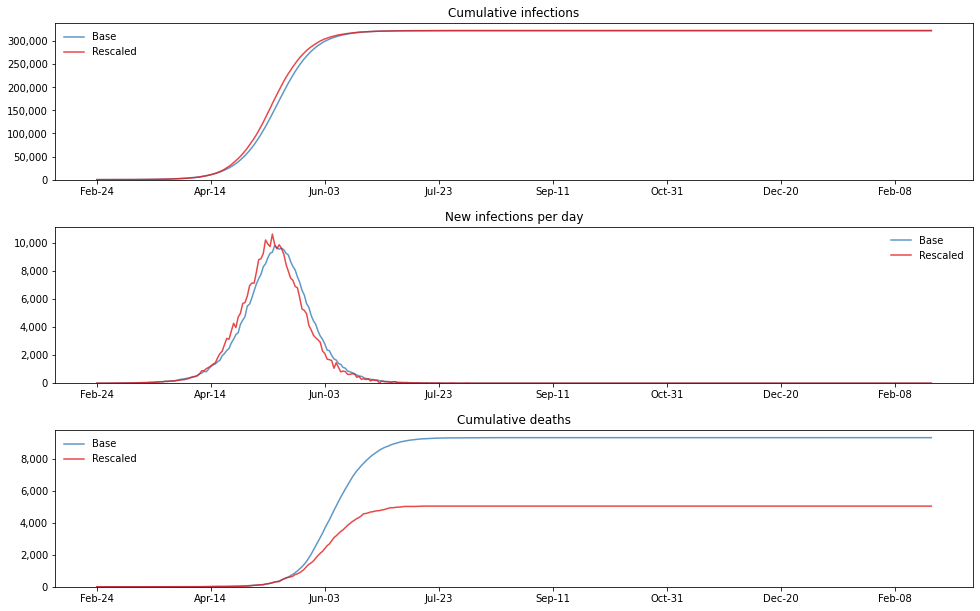

In [20]:
msim = cv.MultiSim([cv.Sim(default_params), cv.Sim(default_params_scale)])
msim.run()
msim.plot(fig_args={"figsize": (15, 9)}, labels=['Base', 'Rescaled']);

## Unknown Parameters

While until now we have taken into consideration only parameters for which we could have given a legitimate value based on real data, there also exist others which are intrinsically unknown but crucial for the evolution of the simulation. Among them there are:

* `pop_infected`: the number of people infected at the beginning of the simulation
* `rel_symp_prob`: a factor that indicates how many of the infected individuals are symptomatic
* `rel_severe_prob`: a factor that indicates how many of the symptomatic individuals show severe symptoms
* `rel_crit_prob`: a factor that indicates how many of the severe individuals show critical symptoms
* `rel_death_prob`: a factor that indicates how many of the critical individuals die

> Note: Despite their name, these last four parameters can assume values in the range $[0, +\infty]$ but their impact seem to lower for values $>10$

Moreover, we must take into consideration that each of the previously discussed interventions has an impact which can't be directly mapped in terms of its parameters.

However, we can exploit the data about the past in terms of positive cases, deaths, hospitalized, in order to determine sensible values for all these unknown parameters. We must perform a *calibration* of our simulator.